In [61]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_RESULTS = os.path.join(PATH, 'results/embeddings')
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'
sys.path.append(os.path.join(PATH, 'src'))
TRAIN_SIZE =  0.01

In [12]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain, product
import re
import json
import matplotlib.pyplot as plt
from nltk import FreqDist, word_tokenize
import seaborn as sns
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
tqdm.pandas()
from twitter_models.embeddings import SentenceEmbeddings
from sklearn.decomposition import TruncatedSVD
from twitter_tools.utils import read_files, batch, VectorDict
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.manifold import TSNE
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE #faster
from sklearn.utils.extmath import randomized_svd
tqdm.pandas()
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')

In [9]:
#load data:
data = pd.DataFrame()
for dat in tqdm(read_files(PATH_DATA, day_from = "2020_02_22", ndays = 84, batch_size = 1, dtype = str)):
    data = data.append(dat[['lemmatized','day','source']])
data.drop_duplicates(inplace = True, subset = 'lemmatized')
print(f'Data loaded. Number of obs {data.shape[0]}')


Data loaded. Number of obs 3003594


### Stratified random sample of the data:

In [15]:
data['lemmatized'] = data['lemmatized'].astype(str).progress_apply(lambda x: [t for t in x.split() if t not in stopwords])

In [19]:
splitter = StratifiedShuffleSplit(n_splits = 84, train_size = TRAIN_SIZE, random_state = 1234)
tr, ts = next(splitter.split(data, data['day'] + data['source']))
print(f'Train size {len(tr)}')
train = data.iloc[tr]

Train size 30035


## Examine the similarity of obtained Tweet-vectors

In [52]:
PATH_EMBS = os.path.join(PATH_RESULTS, 'topic_vecs.p')
if os.path.isfile(PATH_EMBS):
    embs = pickle.load(open(PATH_EMBS, 'rb'))
else:
    embs = dict()
    for nc in trange(3):
        model = SentenceEmbeddings(PATH_EMBEDDINGS, a = 0.1, ncomp = nc)
        embs[nc] = model.fit_transform(train['lemmatized'].tolist())
    pickle.dump(embs, open(PATH_EMBS, 'wb'))

In [47]:
res = dict(model._get_weights(['iść','do','dom','duda']))
res = dict(model._get_weights(['iść','do','dom','duda']))
print(f'Least weighted words: {sorted(res.items(), key = lambda x: x[1])[:20]}')
print(f'Most weighted words: {sorted(res.items(), key = lambda x: x[1], reverse = True)[:20]}')

Least weighted words: [('nie', 0.710207634217636), ('mieć', 0.8513899024746235), ('móc', 0.9479243610577633), ('człowiek', 0.9493268234945998), ('polska', 0.9521121250750356), ('wybory', 0.9547523553800059), ('rok', 0.9607630948491778), ('wiedzieć', 0.9616794288361447), ('siebie', 0.962072678697999), ('chcieć', 0.9632543603460982), ('koronawirus', 0.9634515895657871), ('swój', 0.9642413147720598), ('pis', 0.9647355508019928), ('dobry', 0.9676453047990513), ('czas', 0.9694395417991526), ('dzień', 0.9698391651151127), ('mówić', 0.9706727727810326), ('rząd', 0.9719091453632878), ('robić', 0.9728803980757833), ('prezydent', 0.9741224044771691)]
Most weighted words: [('gościnny', 0.9999645812082059), ('lanka', 0.9999645812082059), ('szably', 0.9999645812082059), ('bolszewika', 0.9999645812082059), ('bolszewo', 0.9999645812082059), ('bystrz', 0.9999645812082059), ('podlizywać', 0.9999645812082059), ('krzemień', 0.9999645812082059), ('dobrzany', 0.9999645812082059), ('reintrodukcja', 0.999964

#### Load fasttext vectors

In [45]:
vocab = FreqDist(chain.from_iterable(data['lemmatized'].tolist()))
fasttext = VectorDict()
fasttext.read(path = PATH_EMBEDDINGS, dim = 300, vocab = vocab)

2000001it [00:48, 41304.05it/s]


In [53]:
for cln in range(3):
    print('\n')
    print(f'Number of components removed {cln}')
    for i in range(20):
        sims = fasttext.most_similar_by_vector(embs[cln][i][np.newaxis], n = 5)
        print(f'Tweet : {train["lemmatized"].iloc[i]}. Most similar words {sims}')



Number of components removed 0
Tweet : ['andrzej', 'duda', 'andrzej', 'duda', 'gościnny', 'sochaczew', 'duda', 'duda', 'bus']. Most similar words [['duda']
 ['andrzej']
 ['tusk']
 ['ryszard']
 ['nowak']]
Tweet : ['tv', 'pis', 'zabrać', 'mld']. Most similar words [['tv']
 ['tvp']
 ['dvbt']
 ['ipli']
 ['tvpis']]
Tweet : ['lanka', 'bój', 'szably', 'dłoń', 'bolszewika', 'gonić', 'słabiutki', 'wynik', 'początek', 'pogonić', 'pis', 'bolszewo']. Most similar words [['bój']
 ['gonić']
 ['pis']
 ['pogonić']
 ['pisior']]
Tweet : ['pis', 'szczujnie', 'trąbić', 'ton', 'przylecieć', 'raptem', 'tir', 'nie', 'brać', 'udział', 'propagandź']. Most similar words [['tir']
 ['ton']
 ['tiry']
 ['brać']
 ['traktor']]
Tweet : ['nie', 'móc', 'siebie', 'darować', 'niedziela', 'rano', 'pisać', 'obrzydliwy', 'ludzin', 'musieć', 'umrzeć', 'mazurek']. Most similar words [['móc']
 ['musieć']
 ['chcieć']
 ['umieć']
 ['przestać']]
Tweet : ['pesel', 'ważny', 'określać', 'śmieć', 'pusty', 'butelka', 'opakowanie', 'le

Tweet : ['szczęście', 'nie', 'siać']. Most similar words [['siać']
 ['zasiać']
 ['posiać']
 ['siejąc']
 ['siała']]
Tweet : ['prosić', 'nie', 'podlizywać', 'związek', 'dziecko', 'nie']. Most similar words [['nie']
 ['wcale']
 ['nigdzie']
 ['przenigdy']
 ['nikt']]
Tweet : ['natura', 'coraz', 'blisko', 'wystarczyć', 'zrobić', 'krok', 'tył', 'rysiek', 'sfotografować', 'wieś', 'krzemień', 'gm', 'dobrzany', 'ramy', 'reintrodukcja', 'gatunek', 'woj', 'zachodniopomorski', 'wypuścić', 'pora', 'ryś', 'zbigniew', 'bolesławski', 'autorek', 'koleżanka']. Most similar words [['gm']
 ['woj']
 ['wojew']
 ['rycki']
 ['ryś']]
Tweet : ['niemiecki', 'medium']. Most similar words [['medium']
 ['niemiecki']
 ['mass']
 ['magnet']
 ['medi']]
Tweet : ['kubia', 'ewuńci', 'dziękować', 'spokojny', 'zrelaksować', 'zdrowy', 'ffback']. Most similar words [['zdrowy']
 ['spokojny']
 ['relaksujący']
 ['odprężający']
 ['komfortowy']]
Tweet : ['członek', 'rada', 'minister', 'móc', 'mieć', 'ochrona', 'funkcjonariusz', 'so

## Examine sentence embeddings in low-dimensional space:

In [54]:
#prepare search space:
params = {'a':[0.1, 0.01, 0.001], 'n': [0, 1, 2]}
keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts

### t-SNE

In [56]:
PATH_TSNE = os.path.join(PATH_RESULTS, 'embeddings/tsne.json')
if os.path.isfile(PATH_TSNE):
    grid = pickle.load(open(PATH_TSNE, 'rb'))
else:
    for i, par in tqdm(enumerate(grid)):
        emb = SentenceEmbeddings(PATH_EMBEDDINGS, a = par['a'], ncomp = par['n'])
        vecs = emb.fit_transform(train['lemmatized'].tolist())
        tsne = TSNE(n_jobs = 4, random_state = 1234)
        grid[i]['tsne'] = tsne.fit_transform(vecs)
    pickle.dump(grid, open(PATH_TSNE, 'wb'))

### Plot the results

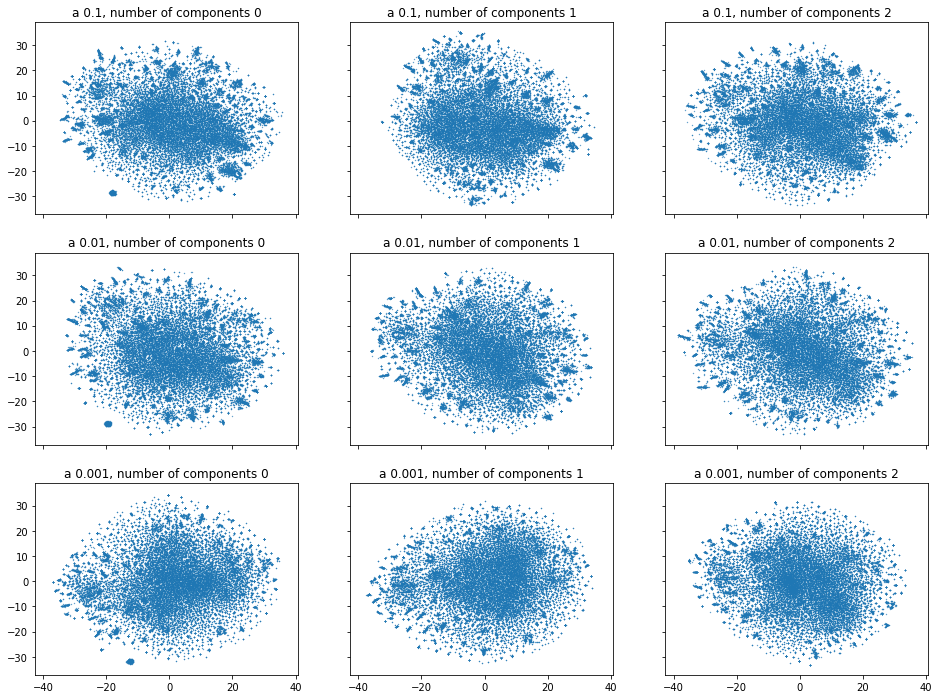

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,12), sharex=True, sharey=True)
ax = ax.ravel()
for i, par in enumerate(grid):
    ax[i].scatter(par['tsne'][:,0], par['tsne'][:,1], s = 0.1)
    ax[i].set_title(f'a {par["a"]}, number of components {par["n"]}')
plt.show()